<a href="https://colab.research.google.com/github/WorldEconomist/Projects/blob/main/Clustering/card_holder_clustering_kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!gdown 1uy92FuBX1o0A838BDcBMv32t0nRpKEb1

Downloading...
From: https://drive.google.com/uc?id=1uy92FuBX1o0A838BDcBMv32t0nRpKEb1
To: /content/CC GENERAL.csv
100% 903k/903k [00:00<00:00, 52.7MB/s]


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.decomposition import PCA
import plotly.express as px

plt.style.use('dark_background')

In [3]:
data = pd.read_csv('CC GENERAL.csv')

#Description
This case requires to develop a customer segmentation to define marketing strategy. The
sample Dataset summarizes the usage behavior of about 9000 active credit card holders during the last 6 months. The file is at a customer level with 18 behavioral variables.
Following is the Data Dictionary for Credit Card dataset :

CUST_ID : Identification of Credit Card holder (Categorical)

BALANCE : Balance amount left in their account to make purchases

BALANCE_FREQUENCY : How frequently the Balance is updated, score between 0 and 1 (1 = frequently updated, 0 = not frequently updated)

PURCHASES : Amount of purchases made from account

ONEOFF_PURCHASES : Maximum purchase amount done in one-go

INSTALLMENTS_PURCHASES : Amount of purchase done in installment

CASH_ADVANCE : Cash in advance given by the user

PURCHASES_FREQUENCY : How frequently the Purchases are being made, score between 0 and 1 (1 = frequently purchased, 0 = not frequently purchased)

ONEOFFPURCHASESFREQUENCY : How frequently Purchases are happening in one-go (1 = frequently purchased, 0 = not frequently purchased)

PURCHASESINSTALLMENTSFREQUENCY : How frequently purchases in installments are being done (1 = frequently done, 0 = not frequently done)

CASHADVANCEFREQUENCY : How frequently the cash in advance being paid

CASHADVANCETRX : Number of Transactions made with "Cash in Advanced"

PURCHASES_TRX : Numbe of purchase transactions made

CREDIT_LIMIT : Limit of Credit Card for user

PAYMENTS : Amount of Payment done by user

MINIMUM_PAYMENTS : Minimum amount of payments made by user

PRCFULLPAYMENT : Percent of full payment paid by user

TENURE : Tenure of credit card service for user

In [4]:
data.head(3)

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.0,0.083333,0.00,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.0,0.000000,0.25,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.0,0.000000,0.00,0,12,7500.0,622.066742,627.284787,0.000000,12


#EDA and Data Preprocessing

In [5]:
len(data[data['MINIMUM_PAYMENTS']>data['PAYMENTS']])/len(data)

0.26424581005586595

How can a MINIMUM_PAYMENTS column be larger than an overall PAYMENTS column in 26% of observations???

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

We've already spotted some missing values and checked column dtypes

In [7]:
data.columns = data.columns.str.lower()

In [8]:
data.shape

(8950, 18)

In [9]:
data.columns.values

array(['cust_id', 'balance', 'balance_frequency', 'purchases',
       'oneoff_purchases', 'installments_purchases', 'cash_advance',
       'purchases_frequency', 'oneoff_purchases_frequency',
       'purchases_installments_frequency', 'cash_advance_frequency',
       'cash_advance_trx', 'purchases_trx', 'credit_limit', 'payments',
       'minimum_payments', 'prc_full_payment', 'tenure'], dtype=object)

In [10]:
data.duplicated(subset = 'cust_id').sum()

0

We've got no duplicates

In [11]:
data.describe()

,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8949.000000,8950.000000,8637.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.449450,1733.143852,864.206542,0.153715,11.517318
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.815725,2895.063757,2372.446607,0.292499,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,169.123707,0.000000,12.000000
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,312.343947,0.000000,12.000000
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,825.485459,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


##Dealing with Missing Values

In [12]:
data.isnull().sum()

,0
cust_id,0
balance,0
balance_frequency,0
purchases,0
oneoff_purchases,0
installments_purchases,0
cash_advance,0
purchases_frequency,0
oneoff_purchases_frequency,0
purchases_installments_frequency,0


In [13]:
data[data['credit_limit'].isnull()]

,cust_id,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure
5203,C15349,18.400472,0.166667,0.0,0.0,0.0,186.853063,0.0,0.0,0.0,0.166667,1,0,NaN,9.040017,14.418723,0.0,6


This single observation is irrelevant as we've got numerous zero variables, we simply can get rid of this row.

In [14]:
data = data.dropna(subset = 'credit_limit')

In [15]:
data[data.isnull().any(axis = 1)]

,cust_id,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.0,12
45,C10047,2242.311686,1.000000,437.00,97.00,340.0,184.648692,0.333333,0.083333,0.333333,0.166667,2,5,2400.0,0.000000,NaN,0.0,12
47,C10049,3910.111237,1.000000,0.00,0.00,0.0,1980.873201,0.000000,0.000000,0.000000,0.500000,7,0,4200.0,0.000000,NaN,0.0,12
54,C10056,6.660517,0.636364,310.00,0.00,310.0,0.000000,0.666667,0.000000,0.666667,0.000000,0,8,1000.0,417.016763,NaN,0.0,12
55,C10057,1311.995984,1.000000,1283.90,1283.90,0.0,0.000000,0.250000,0.250000,0.000000,0.000000,0,6,6000.0,0.000000,NaN,0.0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8919,C19160,14.524779,0.333333,152.00,152.00,0.0,0.000000,0.333333,0.333333,0.000000,0.000000,0,2,1500.0,0.000000,NaN,0.0,6
8929,C19170,371.527312,0.333333,0.00,0.00,0.0,1465.407927,0.000000,0.000000,0.000000,0.166667,5,0,1500.0,0.000000,NaN,0.0,6
8935,C19176,183.817004,1.000000,465.90,0.00,465.9,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1500.0,0.000000,NaN,0.0,6
8944,C19185,193.571722,0.833333,1012.73,1012.73,0.0,0.000000,0.333333,0.333333,0.000000,0.000000,0,2,4000.0,0.000000,NaN,0.0,6


It is sensible enough for us to fill "minimum_payments" column with zeros if corresponding "payments" equals zero too.

In [16]:
data['minimum_payments'] = data.apply(lambda row: 0
                                      if pd.isnull(row['minimum_payments'])
                                      and row['payments'] == 0
                                      else row['minimum_payments'],
                                      axis=1
                                      )

In [17]:
data[data.isnull().any(axis = 1)]

,cust_id,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure
54,C10056,6.660517,0.636364,310.00,0.00,310.00,0.000000,0.666667,0.000000,0.666667,0.000000,0,8,1000.0,417.016763,NaN,0.0,12
99,C10104,0.000000,0.000000,0.00,0.00,0.00,89.849004,0.000000,0.000000,0.000000,0.142857,1,0,3000.0,138.021428,NaN,0.0,7
146,C10152,19.354559,0.909091,689.70,0.00,689.70,0.000000,0.833333,0.000000,0.833333,0.000000,0,10,10000.0,746.691026,NaN,0.0,12
319,C10330,0.478714,0.090909,734.97,159.00,575.97,0.000000,0.833333,0.083333,0.750000,0.000000,0,16,6000.0,1159.135064,NaN,0.0,12
1155,C11198,34.207779,0.090909,2483.26,2483.26,0.00,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,10000.0,29272.486070,NaN,0.0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8561,C18794,3.229304,0.545455,190.20,0.00,190.20,0.000000,0.666667,0.000000,0.583333,0.000000,0,8,1500.0,295.937124,NaN,0.0,12
8593,C18827,16.887571,0.363636,1083.00,1083.00,0.00,0.000000,0.250000,0.250000,0.000000,0.000000,0,3,1200.0,3905.430817,NaN,0.0,12
8647,C18882,0.006651,0.142857,0.00,0.00,0.00,164.137866,0.000000,0.000000,0.000000,0.142857,1,0,1200.0,5.070726,NaN,0.0,7
8753,C18992,0.223351,0.090909,336.00,0.00,336.00,0.000000,1.000000,0.000000,0.916667,0.000000,0,12,1000.0,578.819329,NaN,0.0,12


We still got several missing values, let us fill them in using KNN imputer. This way we can avoid features become less representative for these rows. We can not fill in values with mean as the mean may highly deviate from the true value of the row.

In [18]:
num_cols = data.select_dtypes(include = ['float',
                                         'int64']).columns
num_data = data[num_cols]

In [19]:
imputer = KNNImputer(n_neighbors=5)

In [20]:
imp_data = pd.DataFrame(imputer.fit_transform(num_data),
                        columns=num_cols)

In [21]:
len(imp_data[imp_data['minimum_payments']>imp_data['payments']])/len(imp_data)

0.264945804000447

Lets apply MinMaxScaler to avoid data distrtion and keep distribution the same

In [22]:
scaler = MinMaxScaler()

In [23]:
scaled_array = scaler.fit_transform(imp_data)
scaled_data = pd.DataFrame(scaled_array,
                           columns = num_cols)

#K-Means Clustering

In [24]:
scores = []
silhouette = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k,
                    max_iter=700).fit(scaled_data)
    scores.append(kmeans.inertia_)

    sil_score = silhouette_score(scaled_data,
                                 kmeans.labels_)
    silhouette.append(sil_score)


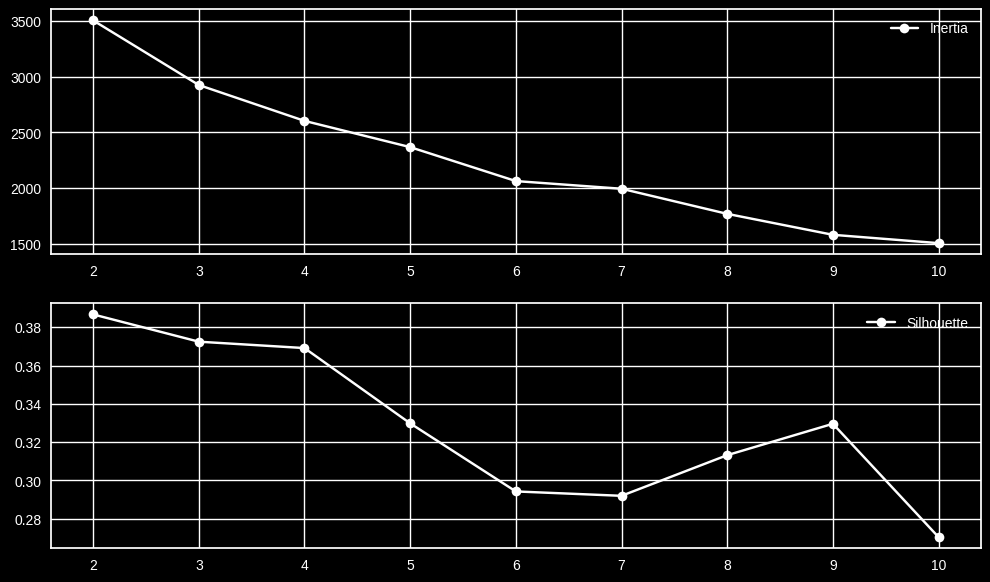

In [25]:
fig, axs = plt.subplots(2, 1, figsize=(12, 7))

axs[0].plot(range(2, 11),
            scores,
            marker = 'o',
            label = 'Inertia',
            color = 'white')
axs[0].legend()

axs[1].plot(range(2, 11),
            silhouette,
            marker = 'o',
            label = 'Silhouette',
            color = 'white')
axs[1].legend()

Both Elbow and Silhouette score show us that 3 as well as 4 clusters might be suitable options for our model. To keep the variety of initial data unchanged we will stick to 4 clusters for a deeper clustering.

In [26]:
kmeans = KMeans(n_clusters=4, max_iter=700)
kmeans.fit(scaled_data)

KMeans(max_iter=700, n_clusters=4)

Returning to our original preprocessed data

In [27]:
labels = kmeans.labels_

In [28]:
cluster_data = pd.DataFrame(scaler.inverse_transform(scaled_data),
                            columns=num_cols)

cluster_data['cluster_id'] = labels
cluster_data.insert(0, 'cust_id', data['cust_id'].values)

cluster_data.head(1)

,cust_id,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure,cluster_id
0,C10001,40.900749,0.818182,95.4,0.0,95.4,0.0,0.166667,0.0,0.083333,0.0,0.0,2.0,1000.0,201.802084,139.509787,0.0,12.0,2


Check if cust_id column was returned correctly with imputed null values.

In [29]:
cluster_data[cluster_data['cust_id']
             .isin(data[data.isnull().any(axis=1)]['cust_id'])]

,cust_id,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure,cluster_id
54,C10056,6.660517,0.636364,310.00,0.00,310.00,0.000000,0.666667,0.000000,0.666667,0.000000,0.0,8.0,1000.0,417.016763,84.151360,0.0,12.0,1
99,C10104,0.000000,0.000000,0.00,0.00,0.00,89.849004,0.000000,0.000000,0.000000,0.142857,1.0,0.0,3000.0,138.021428,100.722831,0.0,7.0,0
146,C10152,19.354559,0.909091,689.70,0.00,689.70,0.000000,0.833333,0.000000,0.833333,0.000000,0.0,10.0,10000.0,746.691026,178.313425,0.0,12.0,1
319,C10330,0.478714,0.090909,734.97,159.00,575.97,0.000000,0.833333,0.083333,0.750000,0.000000,0.0,16.0,6000.0,1159.135064,147.068270,0.0,12.0,1
1155,C11198,34.207779,0.090909,2483.26,2483.26,0.00,0.000000,0.083333,0.083333,0.000000,0.000000,0.0,1.0,10000.0,29272.486070,1006.893566,0.0,12.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8560,C18794,3.229304,0.545455,190.20,0.00,190.20,0.000000,0.666667,0.000000,0.583333,0.000000,0.0,8.0,1500.0,295.937124,49.304000,0.0,12.0,1
8592,C18827,16.887571,0.363636,1083.00,1083.00,0.00,0.000000,0.250000,0.250000,0.000000,0.000000,0.0,3.0,1200.0,3905.430817,115.168078,0.0,12.0,0
8646,C18882,0.006651,0.142857,0.00,0.00,0.00,164.137866,0.000000,0.000000,0.000000,0.142857,1.0,0.0,1200.0,5.070726,56.187891,0.0,7.0,0
8752,C18992,0.223351,0.090909,336.00,0.00,336.00,0.000000,1.000000,0.000000,0.916667,0.000000,0.0,12.0,1000.0,578.819329,95.918425,0.0,12.0,1


Checking cluster distribution

In [30]:
(cluster_data['cluster_id'].value_counts(normalize = True)
                           .sort_index()
                           .reset_index())

,cluster_id,proportion
0,0,0.135322
1,1,0.300257
2,2,0.407755
3,3,0.156666


Calculating overall silhouette score for each cluster

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


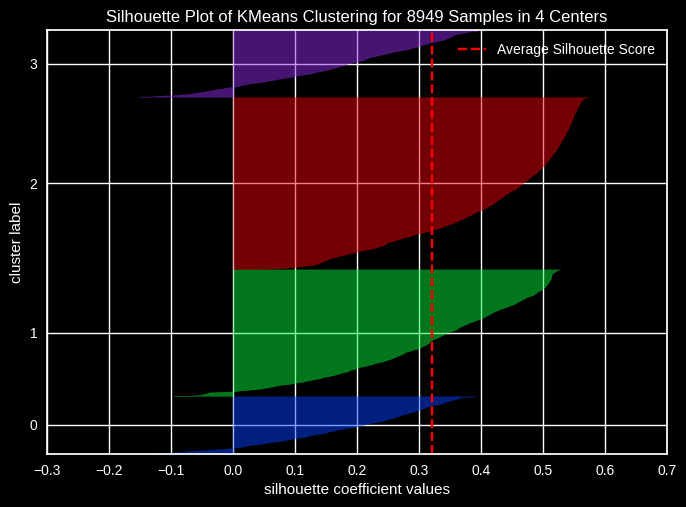

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 8949 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [31]:
visualizer = SilhouetteVisualizer(kmeans,
                                  colors='sns_bright')
visualizer.fit(scaled_data)
visualizer.show()

In [32]:
silhouette_score(scaled_data, kmeans.labels_)

0.32150270124585695

###Results look promising, we've got each cluster's silhouette_score significantly above average.

#Cluster visualization

Let us firstly do 2d and 3d PCA-visualization.

In [33]:
pca = PCA(n_components = 2)

pca_data = pd.DataFrame(
    pca.fit_transform(scaled_data),
    columns = ['pca1', 'pca2']
)

pca_data.shape

(8949, 2)

In [34]:
pca_clusters = pd.concat([pca_data,
                          cluster_data['cluster_id']],
                          axis = 1)
pca_clusters.head()

,pca1,pca2,cluster_id
0,-0.482270,-0.097883,2
1,-0.608709,-0.019550,2
2,0.304348,0.921069,3
3,-0.588701,-0.005697,2
4,-0.554502,0.052620,2


<Axes: xlabel='pca1', ylabel='pca2'>

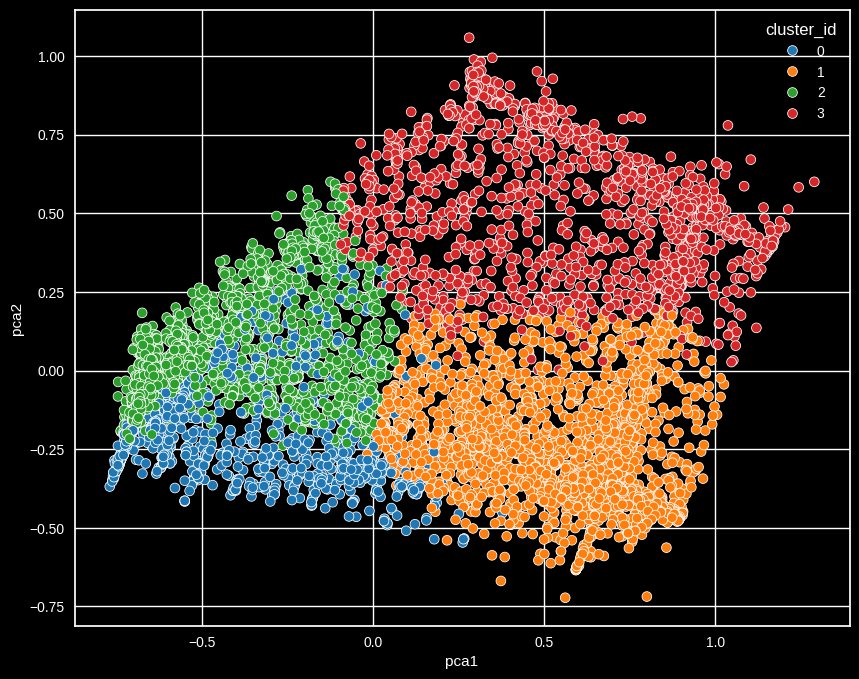

In [35]:
plt.figure(figsize = (10, 8))
sns.scatterplot(data = pca_clusters,
                x = "pca1",
                y = "pca2",
                hue = "cluster_id",
                palette = "tab10")

In [36]:
pca3 = PCA(n_components = 3)

pca3_data = pd.DataFrame(
    pca3.fit_transform(scaled_data),
    columns = ['pca1',
               'pca2',
               'pca3']
)

pca3_data.shape

(8949, 3)

In [37]:
pca3_clusters = pd.concat([pca3_data,
                           cluster_data['cluster_id']],
                           axis = 1)
pca3_clusters.head()

,pca1,pca2,pca3,cluster_id
0,-0.482270,-0.097883,-0.046172,2
1,-0.608709,-0.019550,0.082441,2
2,0.304348,0.921069,0.010725,3
3,-0.588701,-0.005697,0.037247,2
4,-0.554502,0.052620,-0.084023,2


In [38]:
fig = px.scatter_3d (
    pca3_clusters,
    x = 'pca1',
    y = 'pca2',
    z = 'pca3',
    color = 'cluster_id',
    color_continuous_scale = px.colors.sequential.thermal
)

fig.show()

#Clusters interpretation

We will look at each feature using scatter plot matrices and then create a pivot table to perform EDA for a new cluster dataset.

In [39]:
cols = num_cols[num_cols != 'purchases']

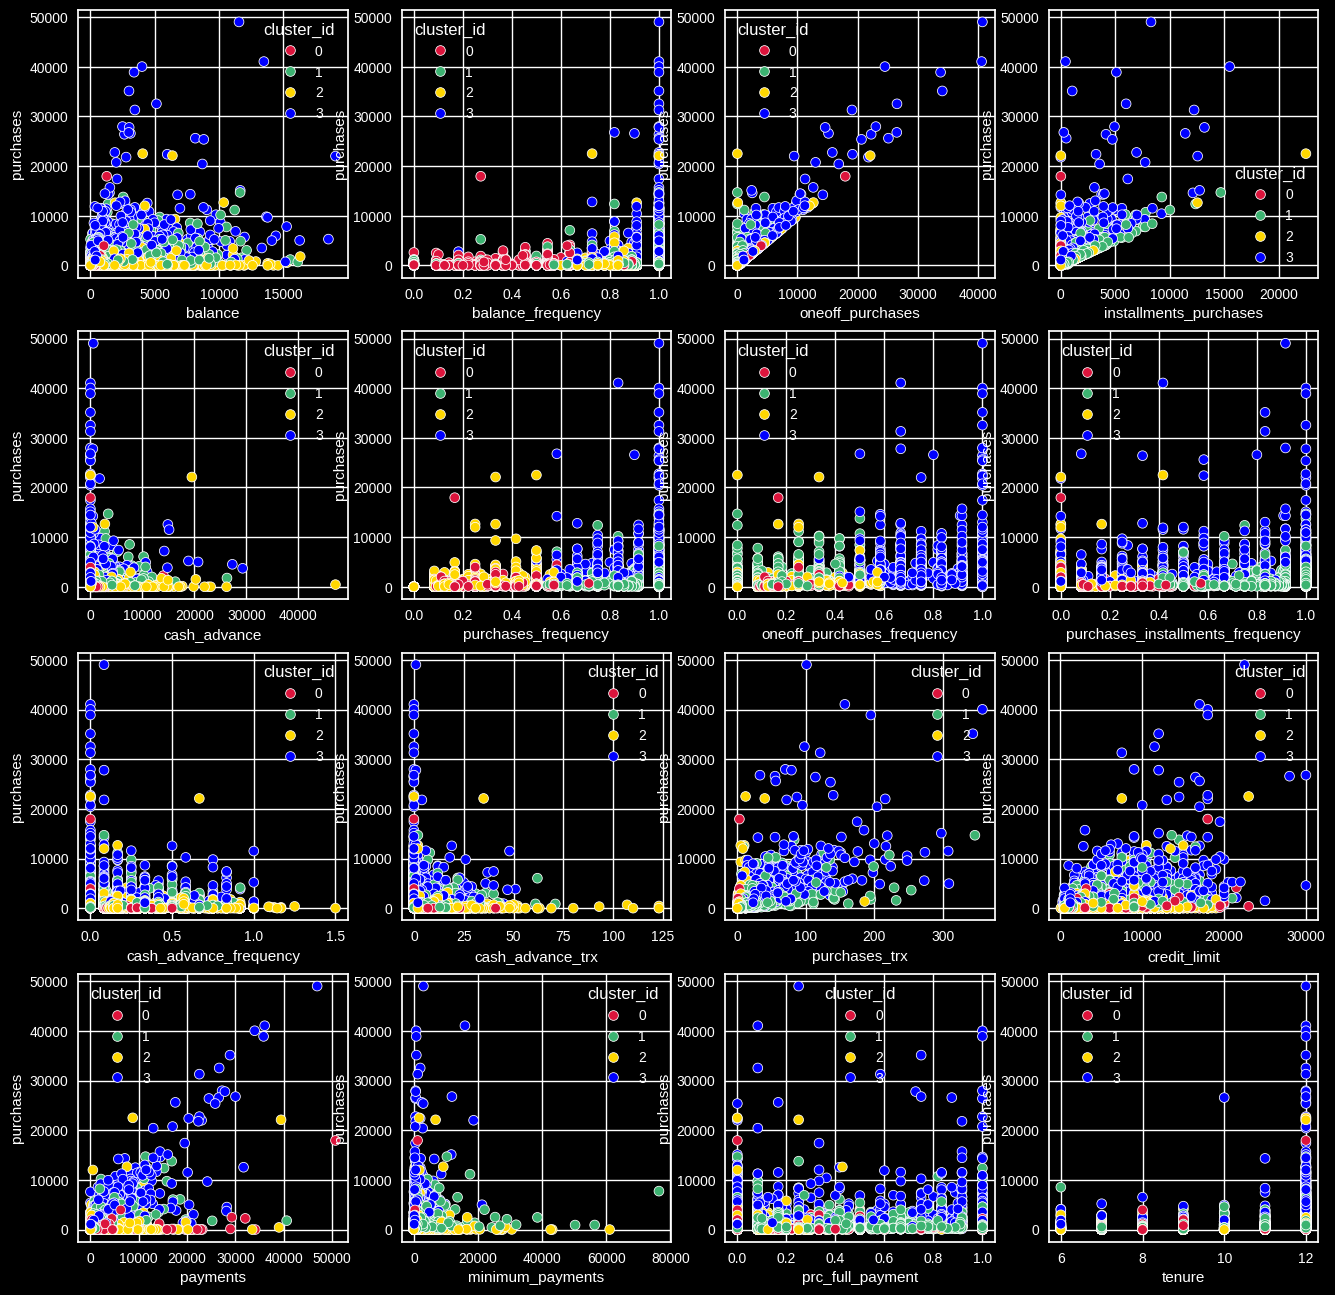

In [40]:
plt.subplots(nrows = 4,
             ncols = 4,
             figsize = (16,16))

palette1 = ["crimson",
            "MediumSeaGreen",
            "gold",
            "blue"]

j=0
for i in cols:
    plt.subplot(4, 4, j+1)
    ax = sns.scatterplot(x=i,
                         y = 'purchases',
                         hue = 'cluster_id',
                         data = cluster_data,
                         palette = palette1)
    j=j+1

In [41]:
pivot = cluster_data.groupby('cluster_id')[cluster_data.columns[1:18]].agg(['min',
                                                                            'mean',
                                                                            'max'])
pivot.T

cluster_id                                        0             1  \
balance                          min       0.000000      0.000000   
                                 mean    153.367481   1179.575654   
                                 max    3947.749703  16115.596400   
balance_frequency                min       0.000000      0.000000   
                                 mean      0.380744      0.929710   
                                 max       1.000000      1.000000   
purchases                        min       0.000000     12.000000   
                                 mean    350.677341   1091.990584   
                                 max   17945.000000  14686.100000   
oneoff_purchases                 min       0.000000      0.000000   
                                 mean    235.756400    280.140808   
                                 max   17945.000000   6345.650000   
installments_purchases           min       0.000000     12.000000   
                                 mean    115.166028    812.517168   
                                 max    4116.000000  14686.100000   
cash_advance                     min       0.000000      0.000000   
                                 mean    508.165440    520.529763   
                                 max   14371.787890  26268.699890   
purchases_frequency              min       0.000000      0.500000   
                                 mean      0.209168      0.883255   
                                 max       0.833333      1.000000   
oneoff_purchases_frequency       min       0.000000      0.000000   
                                 mean      0.073958      0.102362   
                                 max       0.583333      0.583333   
purchases_installments_frequency min       0.000000      0.333333   
                                 mean      0.127128      0.832337   
                                 max       0.750000      1.000000   
cash_advance_frequency           min       0.000000      0.000000   
                                 mean      0.050765      0.073461   
                                 max       0.666667      1.000000   
cash_advance_trx                 min       0.000000      0.000000   
                                 mean      1.142857      1.792706   
                                 max      41.000000     71.000000   
purchases_trx                    min       0.000000      0.000000   
                                 mean      3.406276     21.381838   
                                 max      31.000000    347.000000   
credit_limit                     min     300.000000    400.000000   
                                 mean   3880.748693   3952.725337   
                                 max   23000.000000  21000.000000   
payments                         min       0.000000      0.000000   
                                 mean   1390.851301   1419.406459   
                                 max   50721.483360  40627.595240   
minimum_payments                 min       0.000000      0.000000   
                                 mean    161.346424    940.638297   
                                 max    4287.236670  76406.207520   
prc_full_payment                 min       0.000000      0.000000   
                                 mean      0.246906      0.225288   
                                 max       1.000000      1.000000   
tenure                           min       6.000000      6.000000   
                                 mean     11.322874     11.516561   
                                 max      12.000000     12.000000   

cluster_id                                        2             3  
balance                          min       0.488050      0.000000  
                                 mean   2184.725867   1907.788030  
                                 max   16304.889250  19043.138560  
balance_frequency                min       0.545455      0.000000  
                                 mean      0.966243      0.974591  
   

#**Cluster Profiles**
**Cluster 0 - Light Users:** represents customers who are light users of credit cards, making infrequent purchases, modest cash advances, and having low balances. They are moderate spenders with average credit limits. They do not actively use bank services.

**Cluster 1 - Active Users:** consists of more active users who make frequent purchases (often in installments) and maintain higher balances. They have moderate credit limits and moderate payment behavior, making them engaged credit card users with steady spending patterns.

**Cluster 2 - High Balance, Low Activity:** represents customers who are less focused on purchases but make significant use of cash advances. They maintain high balances and tend to use their credit limit more heavily for advances rather than purchases. Business purpose accounts.

**Cluster 3 - High-spending users:** includes high-spending customers who frequently make large purchases, both in one-off and installment formats. They maintain high balances, often make substantial payments, and have high credit limits. They are heavy credit card users with high financial activity and frequent balance update.